Epoch: 01, Loss: 8.1972, Acc: 0.1420
Epoch: 02, Loss: 6.1103, Acc: 0.1600
Epoch: 03, Loss: 5.0084, Acc: 0.1910
Epoch: 04, Loss: 4.1629, Acc: 0.2300
Epoch: 05, Loss: 3.5178, Acc: 0.2540
Epoch: 06, Loss: 2.9833, Acc: 0.2930
Epoch: 07, Loss: 2.5715, Acc: 0.3290
Epoch: 08, Loss: 2.2379, Acc: 0.3570
Epoch: 09, Loss: 1.9719, Acc: 0.3870
Epoch: 10, Loss: 1.7584, Acc: 0.4120
Epoch: 11, Loss: 1.5846, Acc: 0.4190
Epoch: 12, Loss: 1.4436, Acc: 0.4450
Epoch: 13, Loss: 1.3313, Acc: 0.4690
Epoch: 14, Loss: 1.2402, Acc: 0.5000
Epoch: 15, Loss: 1.1710, Acc: 0.5210
Epoch: 16, Loss: 1.1123, Acc: 0.5460
Epoch: 17, Loss: 1.0673, Acc: 0.5620
Epoch: 18, Loss: 1.0298, Acc: 0.5810
Epoch: 19, Loss: 1.0036, Acc: 0.5870
Epoch: 20, Loss: 0.9774, Acc: 0.6020
Epoch: 21, Loss: 0.9571, Acc: 0.6150
Epoch: 22, Loss: 0.9409, Acc: 0.6260
Epoch: 23, Loss: 0.9277, Acc: 0.6340
Epoch: 24, Loss: 0.9154, Acc: 0.6500
Epoch: 25, Loss: 0.9050, Acc: 0.6600
Epoch: 26, Loss: 0.8975, Acc: 0.6640
Epoch: 27, Loss: 0.8891, Acc: 0.6680
E

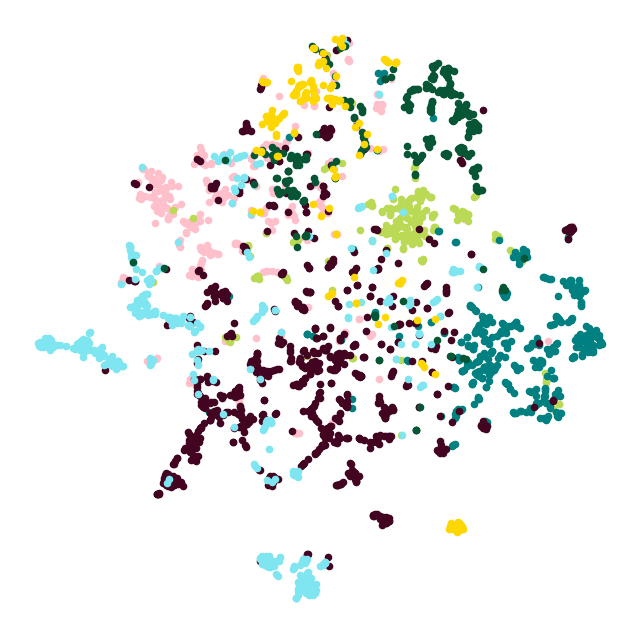

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10, num_negative_samples=1,
                 sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)


def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],
                     z[data.test_mask], data.y[data.test_mask], max_iter=150)
    return acc


for epoch in range(1, 101):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
plot_points(colors)


In [ ]:
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric

In [2]:
data.to_dict()

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

In [8]:
sum(data.val_mask)

tensor(500)

In [9]:
sum(data.train_mask)

tensor(140)

In [10]:
sum(data.test_mask)

tensor(1000)

In [16]:
data.to_dict()

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'edge_index': tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
         [ 633, 1862, 2582,  ...,  598, 1473, 2706]]),
 'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]),
 'val_mask': tensor([False, False, False,  ..., False, False, False]),
 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}

In [15]:
from torch_geometric.data import Data

test_dict = Data()

In [17]:
test_dict.from_dict({
    "x": [[0, 0, 1], [1, 0, 0], [0, 1, 0]],
    "y": [0, 1, 2],
})

Data(x=[3], y=[3])

In [18]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [20]:
data.x[0]

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [21]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [22]:
data.num_edges

10556